# Lab 6: Introduction to Deep Learning

This is an important lab session which aims to develop intuition for Deep Reinforcement Learning(DRL). 
For those familiar with Deep Learning(DL), you'll get to brush up some concepts. For those unfamiliar with this lab session it will be crash course of DL.

We'll use PyTorch, a popular tool for upcoming DRL lab sessions. 
Please go through jupyter notebooks in order Lab_session6_1 then Lab_session6_2 before reading further instructions.

Open your Virtualenvironment and install requirements.txt by running
`pip install -r requirements.txt --user`

After going through the Notebooks and getting a hang of the way PyTorch works, we will ask you to play around with the hyperparameters to fine-tune and techniques you can use to greatly improve your network's performance, and get a better intuition for the how and why it works.

## 0. Loading the Data: the classic MNIST dataset
The dataset we will use is MNIST, consisting of 60k hand-written digits; the goal is to tell which number is on the image, or in other words to "read" hand-written digits. There are 10k testing samples in addition to the 60k training samples.

We will be using [this tuto](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118) as a guide for most of the prep work.

In [1]:
import torch
import matplotlib
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



Let's see how these look:

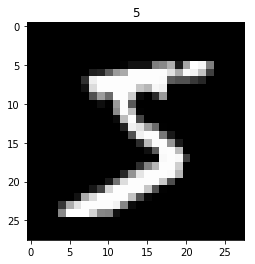

In [3]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

We will want to sample from the test or train set during training and testing. In order to do this automatically, we use DataLoaders:

In [5]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100,
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1e0a6644438>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1e0a6644d30>}

----------

## 1. The Multi Layer Perceptron(MLP)

A multilayer perceptron (MLP) is a class of feed forward artificial neural network (ANN). Multilayer perceptrons are sometimes colloquially referred to as "vanilla" neural networks, especially when they have a single hidden layer.

<!-- ![image.png](attachment:image.png)
 -->
<img src=https://scikit-learn.org/stable/_images/multilayerperceptron_network.png alt="drawing" width="400"/>

[Image source](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)

The above image shows one hidden layer MLP with scaler output 


Most of the following can be visualized beforehand on a toy problem using the [Tensorflow Playground](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2&seed=0.35230&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

On this playground, you can change the inputs, depth and width of the network, learning rate, task and noise, activation function, regularizer, batch size. We very strongly recommend you give it some time to play around, as it is excellent to build an intuition and understand the impact of all the choices the NN designer makes.

In [6]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

### Network architecture
Three main choices can be made about an MLP's architecture:
* *depth*: number of hidden layers
* *width*: number of neurons in each layer
* *non-linearity*: activation functions

First, playing around with the depth of the network - the depth is defined by the number of functions you add in the init method of the Net class.

**Note that** for 0 hidden layers, we have a regular linear model. 

Using only one hidden layer, but with sufficient width, ensures that the network is a Universal Approximator (can approximate any function). 

The activation functions can have a very important impact on the network. It is common practice to choose the same for all layers, except the output layer, which controls the nature of the overall function (net). First, visualize, using TF Playground, the difference in hypothesis (function shape) when changing function. The sigmoid function is historically important, but has near 0 gradient for high absolute values, which makes the gradient vanish. Try to compare performance in MNIST between sigmoid and more recent activation functions like ReLU or tanh.

In [7]:
IN_DIM = 28*28
OUT_DIM = 10

In [8]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(IN_DIM, 100) # Wx + b
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, OUT_DIM)

    def forward(self, X):
        X = X.squeeze(1)
        X = X.flatten(-2,-1)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.log_softmax(self.fc3(X), dim=-1)

        return X

In [9]:
net = Net()

### Learning Rate and Optimizer
The learning rate of the gradient descent is a very common and crucial hyperparameter is a lot of ML applications, including Deep Learning.
Try tweaking it - you should observe that high values lead to unstable learning, but low values lead to slow learning.

Using simply the SGD update w -= alpha*grad_w(J) is often very naive, and prone to stochasticity. Lately, a lot of methods have appeared to try and add momentum, vary the learning rate depending on the specific parameter, etc. In PyTorch, the optimizer is selected using
`optimizer = torch.optim.SGD(net.parameters(), lr=0.01)`

### Loss and Regularization
The most common loss to optimize is simply the Means Squared Error, (h(x) - y)² - trying to minimize the distance between your prediction and the ground truth. However, other measures can be used. After documenting yourself, try comparing MSE with the Cross Entropy Loss in PyTorch on the MNIST problem.

A very common cause for overfitting is that the network weights explode - if you try to fit 10 2D points with a 10 degree polynomial, you will often find very high weight values that lead to severe overfitting, rather than truly trying to find the trend.
In order to prevent weight explosion, *L2 Regularization* add a soft constraint to the loss under the form of a lambda*||w||\_2 term (L1 Reg uses norm 1). This way, the optimizer tries to solve the task using weights as small as possible. Conveniently in PyTorch, as you can see in the doc, the Regularization ("weight decay") is an optional argument to the optimizer!

In [10]:
criterion = nn.CrossEntropyLoss()# cross entropy loss
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [11]:
# for convenience
def reset(net_class, criterion_class, optim_class, lr):
    net = net_class()
    criterion = criterion_class() # cross entropy loss
    optimizer = optim_class(net.parameters(), lr=lr)
    return net, criterion, optimizer

Try to observe that, for a very wide layer, the network overfits to the testing data (...leading to a suspicious wine quality accuracy). The width can be controlled by changing how many inputs and outputs each intermediate function (i.e. hidden layer) takes in and gives out.

### Batch size
The reason the optimizer is called Stochastic Gradient Descent, as opposed to usual Gradient Descent, is because we only use subsets (batches) of the training data instead of the whole thing at once, acting like a sample in a stochastic computation. This was found to lead to great gains in wall-clock performance, since we don't have to loop over the whole dataset, which might be millions of entries big. In particular, this has lead to huge gains in efficiency thanks to GPUs, massively excelling in parallelized computing but with limited RAM that cannot hold the whole dataset at once.

### (Dropout)
The neurons of a neural network are extremely heavily dependent on the values of the previous neurons - each of the inputs can have a drastic impact on the output. This is often a major culprit for overfitting, where the neurons cannot generalize properly because the new testing distribution looks very different from the training distribution.
In order to prevent these heavy dependencies, one of the core techniques of Deep Learning was invented: Dropout. This simply means that in training, each neuron has some probability to be turned off altogether! This means that the downstream neurons need to be flexible enough to adapt to all kinds of changes in input; no rely too heavily on a single input, but rather find valuable information in all of it.
Dropout can conveniently be seen as an [https://pytorch.org/docs/stable/nn.html#dropout-layers](additional layer), that you can add after any layer (except the output), with a constant giving the probability to turn the neuron off.


In [12]:
def plot(steps, test_steps, losses, test_losses, accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(steps, losses, label="train loss")
    ax1.plot(test_steps, test_losses, label="test loss")
    ax1.set_title("Losses")
    ax1.legend()
    ax1.set_ylim(0,None)
    ax2.plot(test_steps, accuracies)
    ax2.set_title("Accuracy")
    ax2.set_ylim(0,1)
    plt.show()

In [13]:
from torch.autograd import Variable 
num_epochs = 10
def train(num_epochs, loaders, net, optimizer, criterion):
    # Visualization stuff
    losses = []
    test_losses = []
    accuracies = []
    step = 0
    steps = []
    test_steps = []
    
    # Learning stuff
    total_step = len(loaders['train'])
    # Set the net to training mode:
    net.train()
    # Learning loop:
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']): # extracts batches of data using loaders
            b_x = Variable(images)
            b_y = Variable(labels)
            output = net(b_x)
            # Compute loss; compute gradient (backprop); apply SGD
            loss = criterion(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            step += 1
            
            if (i+1) % 200 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                        # testing
                test_loss, acc = test(net, criterion)
                test_losses.append(test_loss)
                accuracies.append(acc)
                test_steps.append(step)
                
            losses.append(loss.item())
            steps.append(step)
        
    return steps, test_steps, losses, test_losses, accuracies 
        
def test(net, criterion):
    # Test the model
    net.eval()    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output = net(images)
            test_loss = criterion(test_output, labels)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print('\tTest Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
    return test_loss, accuracy

In [ ]:
net, criterion, optimizer = reset(Net, nn.CrossEntropyLoss, torch.optim.SGD, lr=0.005)
results = train(10, loaders, net, optimizer, criterion)

Epoch [1/10], Step [200/600], Loss: 2.2679
	Test Accuracy of the model on the 10000 test images: 0.21
Epoch [1/10], Step [400/600], Loss: 2.2323
	Test Accuracy of the model on the 10000 test images: 0.44
Epoch [1/10], Step [600/600], Loss: 2.1538
	Test Accuracy of the model on the 10000 test images: 0.45
Epoch [2/10], Step [200/600], Loss: 2.0591
	Test Accuracy of the model on the 10000 test images: 0.55
Epoch [2/10], Step [400/600], Loss: 1.8230
	Test Accuracy of the model on the 10000 test images: 0.59
Epoch [2/10], Step [600/600], Loss: 1.6011
	Test Accuracy of the model on the 10000 test images: 0.72
Epoch [3/10], Step [200/600], Loss: 1.2293


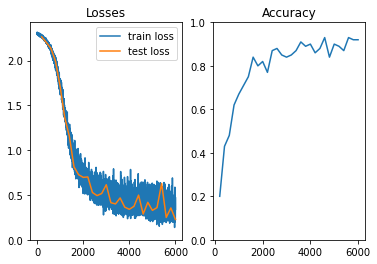

In [24]:
steps, test_steps, losses, test_losses, accuracies = results
plot(steps, test_steps, losses, test_losses, accuracies)

### Changing the optimizer: Adam
The neural does learn! The loss is getting more and more noisy, indicating that the network could benefit from a lower learning rate. However, you can try yourself that a lower learning rate makes training much longer, as the network struggles to find a sweet spot in the parameter space. Coming up with a schedule to decrease the value of the learning rate would be even more laborious than finding a single good learning rate value!

Instead, we want to change the optimizer itself. SGD is very naive; Adam is a much smarter optimizer that adapts the learning rate per-parameter, and uses momentum to move more smoothly in the parameter space. Let's see how it performs! We can afford to use a much lower learning rate, as Adam will make bigger first steps and later fine-tune.



In [25]:
net, criterion, optimizer = reset(Net, nn.CrossEntropyLoss, torch.optim.Adam, lr=0.0005)
results_adam = train(10, loaders, net, optimizer, criterion)

Epoch [1/10], Step [200/600], Loss: 0.3558
	Test Accuracy of the model on the 10000 test images: 0.94
Epoch [1/10], Step [400/600], Loss: 0.1668
	Test Accuracy of the model on the 10000 test images: 0.88
Epoch [1/10], Step [600/600], Loss: 0.2294
	Test Accuracy of the model on the 10000 test images: 0.94
Epoch [2/10], Step [200/600], Loss: 0.1588
	Test Accuracy of the model on the 10000 test images: 0.95
Epoch [2/10], Step [400/600], Loss: 0.2928
	Test Accuracy of the model on the 10000 test images: 0.96
Epoch [2/10], Step [600/600], Loss: 0.1840
	Test Accuracy of the model on the 10000 test images: 0.88
Epoch [3/10], Step [200/600], Loss: 0.1958
	Test Accuracy of the model on the 10000 test images: 0.96
Epoch [3/10], Step [400/600], Loss: 0.2977
	Test Accuracy of the model on the 10000 test images: 0.92
Epoch [3/10], Step [600/600], Loss: 0.1677
	Test Accuracy of the model on the 10000 test images: 0.94
Epoch [4/10], Step [200/600], Loss: 0.0528
	Test Accuracy of the model on the 1000

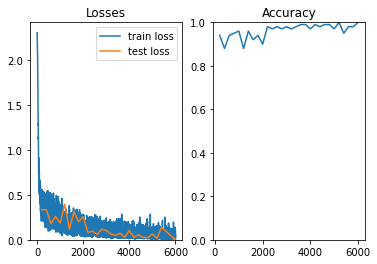

In [26]:
steps, test_steps, losses, test_losses, accuracies = results_adam
plot(steps, test_steps, losses, test_losses, accuracies)

## 2. Convolutional Neural Network
Abbraviated CNNs, Convolutional Neural Nets are Artifical Neural Networks with image-specific Convolution layers that are designed to handle visual inputs. In a way, they are less general, 

In [28]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 3)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(1152, OUT_DIM)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten
        x = self.fc1(x) # fully connected
        output = F.log_softmax(x, dim=1)  
        return output

In [29]:
net, criterion, optimizer = reset(CNNet, nn.CrossEntropyLoss, torch.optim.Adam, lr=0.001)
results_cnn = train(10, loaders, net, optimizer, criterion)

Epoch [1/10], Step [200/600], Loss: 0.1982
	Test Accuracy of the model on the 10000 test images: 0.94
Epoch [1/10], Step [400/600], Loss: 0.2496
	Test Accuracy of the model on the 10000 test images: 0.96
Epoch [1/10], Step [600/600], Loss: 0.2273
	Test Accuracy of the model on the 10000 test images: 0.96
Epoch [2/10], Step [200/600], Loss: 0.1737
	Test Accuracy of the model on the 10000 test images: 0.98
Epoch [2/10], Step [400/600], Loss: 0.2020
	Test Accuracy of the model on the 10000 test images: 1.00
Epoch [2/10], Step [600/600], Loss: 0.1223
	Test Accuracy of the model on the 10000 test images: 0.96
Epoch [3/10], Step [200/600], Loss: 0.1139
	Test Accuracy of the model on the 10000 test images: 0.97
Epoch [3/10], Step [400/600], Loss: 0.0812
	Test Accuracy of the model on the 10000 test images: 0.97
Epoch [3/10], Step [600/600], Loss: 0.0858
	Test Accuracy of the model on the 10000 test images: 0.99
Epoch [4/10], Step [200/600], Loss: 0.0666
	Test Accuracy of the model on the 1000

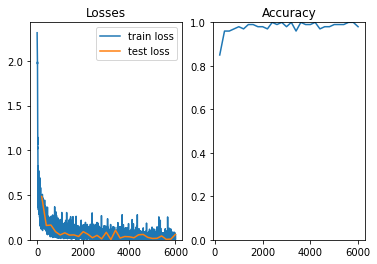

In [62]:
steps, test_steps, losses, test_losses, accuracies = results_cnn
plot(steps, test_steps, losses, test_losses, accuracies)